In [95]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import seaborn as sns
from kerastuner.tuners import RandomSearch
from tensorflow.keras.layers import BatchNormalization

In [96]:
# Loading the Data
data = pd.read_csv("C:/Users/Salma/Downloads/heart_disease_health_indicators.csv")

In [97]:
data.head()

,HeartDiseaseorAttack,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0,1,1,1,40,1,0,0,0,0,...,1,0,5,18,15,1,0,9,4,3
1,0,0,0,0,25,1,0,0,1,0,...,0,1,3,0,0,0,0,7,6,1
2,0,1,1,1,28,0,0,0,0,1,...,1,1,5,30,30,1,0,9,4,8
3,0,1,0,1,27,0,0,0,1,1,...,1,0,2,0,0,0,0,11,3,6
4,0,1,1,1,24,0,0,0,1,1,...,1,0,2,3,0,0,0,11,5,4


In [98]:
# It seems that the data is unbalanced
data['HeartDiseaseorAttack'].value_counts()

0    229773
1     23888
Name: HeartDiseaseorAttack, dtype: int64

In [99]:
# Dropping null values
data = data.dropna()

In [100]:
# Separate features and target
X = data.drop(columns=['HeartDiseaseorAttack'])
y = data['HeartDiseaseorAttack']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [101]:
# Split into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [102]:
# Define the model-building function for Keras Tuner
def model_builder(hp):
    model = Sequential()
    
    # Tune the number of units in the first Dense layer
    hp_units1 = hp.Int('units1', min_value=32, max_value=128, step=32)
    model.add(Dense(units=hp_units1, activation='sigmoid', input_shape=(X_train.shape[1],)))
    
    model.add(BatchNormalization()) # Weight normalization
    
    # Second hidden layer 
    hp_units2 = hp.Int('units2', min_value=32, max_value=128, step=32)
    model.add(Dense(units=hp_units2, activation='sigmoid'))
    
    model.add(BatchNormalization()) # Weight normalization
    
    # Add Dropout layer with tuneable rate
    hp_dropout = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    model.add(Dropout(hp_dropout))
    
    # Third hidden layer
    hp_units3 = hp.Int('units3', min_value=32, max_value=128, step=32)
    model.add(Dense(units=hp_units3, activation='sigmoid'))
    
    model.add(BatchNormalization()) # Weight normalization
    
    # Output layer
    model.add(Dense(1, activation='sigmoid'))  # Binary classification
    
    # Compile the model
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model


In [103]:
# Initialize the tuner
tuner = RandomSearch(
    model_builder,
    objective='val_accuracy',
    max_trials=5,  
    executions_per_trial=2,  # Number of models to build and average the results
    directory='heart_disease_tuning',
    project_name='heart_disease_prediction3.2')

# Searching for the best hyperparameters
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42) # Splitting data into train and validate sets
tuner.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

Trial 5 Complete [00h 04m 00s]
val_accuracy: 0.9083550870418549

Best val_accuracy So Far: 0.9084413349628448
Total elapsed time: 00h 19m 11s


In [104]:
# Get the best model with the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)

In [105]:
# Train the best model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=32)

Epoch 1/30
5074/5074 [==============================] - 12s 2ms/step - loss: 0.2569 - accuracy: 0.9015 - val_loss: 0.2511 - val_accuracy: 0.9061
Epoch 2/30
5074/5074 [==============================] - 11s 2ms/step - loss: 0.2455 - accuracy: 0.9056 - val_loss: 0.2404 - val_accuracy: 0.9085
Epoch 3/30
5074/5074 [==============================] - 11s 2ms/step - loss: 0.2447 - accuracy: 0.9055 - val_loss: 0.2396 - val_accuracy: 0.9068
Epoch 4/30
5074/5074 [==============================] - 10s 2ms/step - loss: 0.2438 - accuracy: 0.9057 - val_loss: 0.2430 - val_accuracy: 0.9077
Epoch 5/30
5074/5074 [==============================] - 10s 2ms/step - loss: 0.2431 - accuracy: 0.9060 - val_loss: 0.2404 - val_accuracy: 0.9080
Epoch 6/30
5074/5074 [==============================] - 10s 2ms/step - loss: 0.2426 - accuracy: 0.9061 - val_loss: 0.2392 - val_accuracy: 0.9079
Epoch 7/30
5074/5074 [==============================] - 10s 2ms/step - loss: 0.2420 - accuracy: 0.9066 - val_loss: 0.2396 - val_ac

1586/1586 [==============================] - 2s 1ms/step


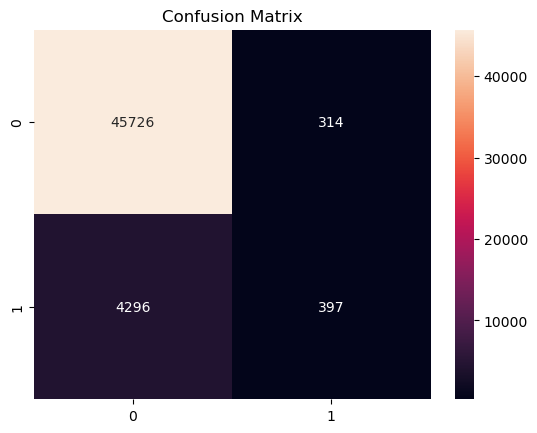

              precision    recall  f1-score   support

           0       0.91      0.99      0.95     46040
           1       0.56      0.08      0.15      4693

    accuracy                           0.91     50733
   macro avg       0.74      0.54      0.55     50733
weighted avg       0.88      0.91      0.88     50733

1586/1586 [==============================] - 2s 1ms/step


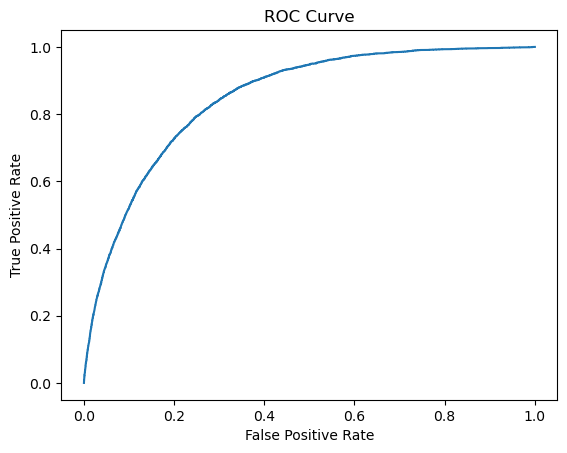

ROC-AUC Score: 0.85


In [106]:
# Confusion Matrix
y_pred = (model.predict(X_test) > 0.5).astype('int32')
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.savefig(r"C:\Users\Salma\Desktop\Confusion Matrix.png", format='png')
plt.show()

# Classification Report
print(classification_report(y_test, y_pred))

# ROC-AUC Curve
y_pred_prob = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr, label='ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.savefig(r"C:\Users\Salma\Desktop\ROC Curve.png", format='png')
plt.show()

# ROC-AUC Score
auc_score = roc_auc_score(y_test, y_pred_prob)
print(f'ROC-AUC Score: {auc_score:.2f}')

In [107]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.2f}')

1586/1586 [==============================] - 2s 1ms/step - loss: 0.2347 - accuracy: 0.9091
Test Accuracy: 0.91


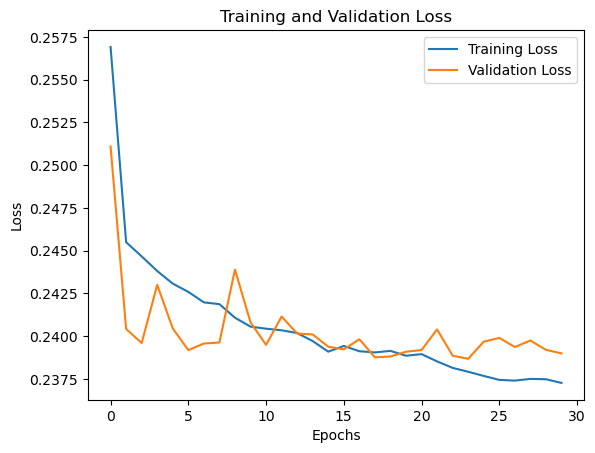

In [109]:
# Visualize Training and Validation Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(r"C:\Users\Salma\Desktop\Lossplot.png", format='png')
plt.show()
